In [1]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter, Augmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
config = load_yaml_param_settings("configs/config.yaml")

config['dataset']['dataset_name'] = 'UWaveGestureLibraryAll'
config["VQVAE"]["n_fft"] = 8

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader_aug = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True
)
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)

test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])

self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


In [65]:
for batch in train_data_loader_aug:
    x_batch, y = batch
    break

In [77]:
from utils import time_to_timefreq, timefreq_to_time


In [123]:
x, xaug = x_batch

u = time_to_timefreq(x, config["VQVAE"]["n_fft"], x.shape[1])
u_aug = time_to_timefreq(xaug, config["VQVAE"]["n_fft"], x.shape[1])
z_1 = encoder(u)
z_2 = encoder(u_aug)

In [106]:
print(x.shape)

torch.Size([128, 1, 945])


In [124]:
def random_crop(*subx_views):
    """
    Apply random cropping to input sequences based on self.window_ratio.

    Parameters:
    - subx_views: Variable number of input sequences (batch_size, channels, subseq_len).

    Returns:
    - cropped_views: List of cropped sequences.
    """

    cropped_views = []
    for subx in subx_views:
        subseq_len = subx.shape[-1]
        crop_size = int(0.5 * subseq_len)  # Calculate crop size based on self.window_ratio
        start_idx = np.random.randint(0, subseq_len - crop_size + 1)  # Generate a random start index for the crop
        cropped_view = subx[:, :, start_idx:start_idx + crop_size]  # Use slicing to crop the subx_view

        cropped_views.append(cropped_view)

    if len(cropped_views) == 1:
        cropped_views = cropped_views[0]

    return cropped_views

def random_crop(self, *x_views):
    subx_views = []
    rand_ts = []
    subseq_len = 10
    for i in range(len(x_views)):
        seq_len = x_views[i].shape[-1]
        rand_t = np.random.randint(0, seq_len - subseq_len + 1, size=1)[0]
        subx = x_views[i][:, rand_t: rand_t + subseq_len]  # (subseq_len)
        subx_views.append(subx)
        rand_ts.append(rand_t)

    if len(subx_views) == 1:
        subx_views = subx_views[0]
    return subx_views

TypeError: list indices must be integers or slices, not tuple

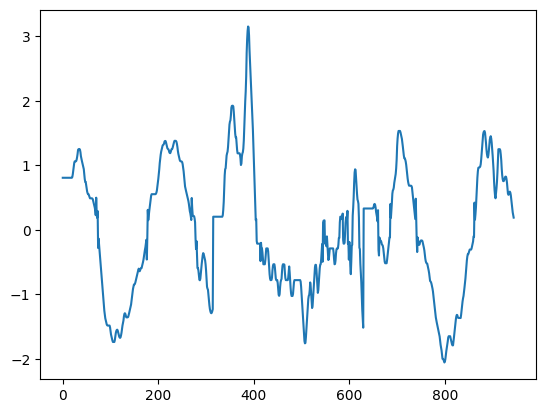

In [139]:


xaug = random_crop(xaug, 10)
plt.plot(x[0, 0])
plt.plot(xaug[0, 0])


In [136]:
def random_crop(self, subseq_len: int, *x_views):
    subx_views = []
    rand_ts = []
    for i in range(len(x_views)):
        seq_len = x_views[i].shape[-1]
        rand_t = np.random.randint(0, seq_len - subseq_len + 1, size=1)[0]
        subx = x_views[i][:, rand_t: rand_t + subseq_len]  # (subseq_len)
        subx_views.append(subx)
        rand_ts.append(rand_t)

    if len(subx_views) == 1:
        subx_views = subx_views[0]
    return subx_views

TypeError: list indices must be integers or slices, not tuple

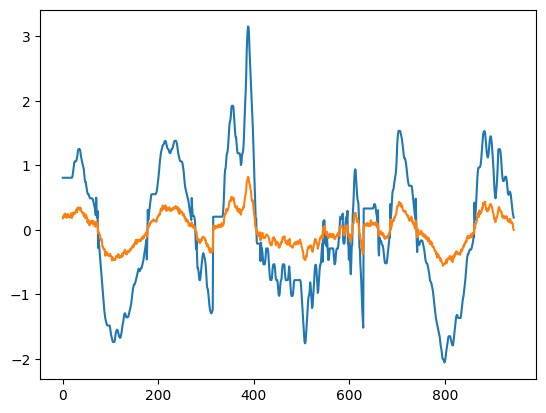

In [137]:
for batch in train_data_loader_aug:
    x_batch, y = batch
    break

x, xaug = x_batch
xaug_cropped = random_crop(xaug, 10)

plt.plot(x[0, 0])
plt.plot(xaug[0, 0])
plt.plot(xaug_cropped[0, 0])

u1 = time_to_timefreq(x, config["VQVAE"]["n_fft"], x.shape[1])
uaug = time_to_timefreq(xaug_cropped, config["VQVAE"]["n_fft"], x.shape[1])

z1 = encoder(u1)
z2 = encoder(uaug)





In [66]:
from experiments.exp_vqvae import Exp_VQVAE

input_length = train_data_loader.dataset.X.shape[-1]

train_exp = Exp_VQVAE(
    input_length,
    config=config,
    n_train_samples=len(train_data_loader.dataset),
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
)
encoder = train_exp.encoder

In [67]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)



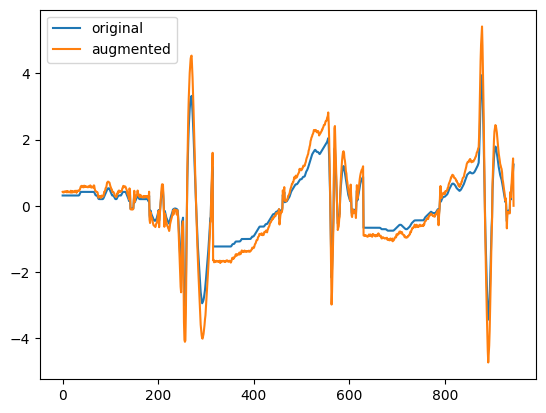

In [57]:

config = load_yaml_param_settings("configs/config.yaml")


aug = Augmenter(**config["augmentations"])


x, _ = get_x_u()
xaug = aug.augment(x)
plt.plot(x, label="original")
plt.plot(xaug, label="augmented")  # Include the augmented signal in the plot
plt.legend()
plt.show()#plot the original and augmented signals